# AutoARIMA Forecasting with Nixtla's NeuralForecast

## Dataset: AV

This notebook demonstrates how to use the AutoARIMA forecasting model
with the implementation provided by Nixtla's StatsForecast library:

## Important note:

This notebook uses the following conda environments:

+ Under linux: tfm_cc, described in the tfm_cc.yml file (see environments folder).
+ Under macOS: tfm_cc_nixtla, described in the tfm_cc_nixtla.yml file (see environments folder). 

## Execution Notes:

The run times that appear below correspond to the execution of the notebook in a Mac M2 machine, 16GB of RAM.

## Load basic libraries

**Warning:** Model specific libraries will be loaded below.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import time
import logging



from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error



## Load dataset

In [2]:
file_path = "../../data/filtered_df.csv"
df = pd.read_csv(file_path, delimiter=';')
df.head()

,time,Active_Power,Wind_speed_tower,Preassure,Generator_Speed,F1_v(90).Mean,F1_v(80).Mean,F1_v(70).Mean,F1_v(60).Mean,F1_v(50).Mean,F1_v(40).Mean,F1_v(30).Mean
0,01/09/2022 0:00,2505.48220,9.057124,1012.38360,1121.2102,9.023969,3.97405,9.076108,3.82628,8.992466,3.39136,8.827003
1,01/09/2022 1:00,1762.24210,8.078237,1012.41210,1073.9020,8.110137,3.97405,8.151952,3.82628,8.076786,3.39136,8.005285
2,01/09/2022 2:00,1460.83560,7.712017,1012.29083,1021.2429,7.527431,3.97405,7.615797,3.82628,7.517593,3.39136,7.461551
3,01/09/2022 3:00,926.81006,6.672135,1012.15690,894.0004,6.566134,3.97405,6.637816,3.82628,6.571112,3.39136,6.550666
4,01/09/2022 4:00,671.34590,6.100095,1012.09424,821.4349,5.988185,3.97405,6.049537,3.82628,5.986922,3.39136,5.982606


### Set datetime format and index

In [3]:
df['time'] = pd.to_datetime(df['time'], format='%d/%m/%Y %H:%M')
df.set_index('time', inplace=True)
df.head()

,Active_Power,Wind_speed_tower,Preassure,Generator_Speed,F1_v(90).Mean,F1_v(80).Mean,F1_v(70).Mean,F1_v(60).Mean,F1_v(50).Mean,F1_v(40).Mean,F1_v(30).Mean
time,,,,,,,,,,,
2022-09-01 00:00:00,2505.48220,9.057124,1012.38360,1121.2102,9.023969,3.97405,9.076108,3.82628,8.992466,3.39136,8.827003
2022-09-01 01:00:00,1762.24210,8.078237,1012.41210,1073.9020,8.110137,3.97405,8.151952,3.82628,8.076786,3.39136,8.005285
2022-09-01 02:00:00,1460.83560,7.712017,1012.29083,1021.2429,7.527431,3.97405,7.615797,3.82628,7.517593,3.39136,7.461551
2022-09-01 03:00:00,926.81006,6.672135,1012.15690,894.0004,6.566134,3.97405,6.637816,3.82628,6.571112,3.39136,6.550666
2022-09-01 04:00:00,671.34590,6.100095,1012.09424,821.4349,5.988185,3.97405,6.049537,3.82628,5.986922,3.39136,5.982606


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7248 entries, 2022-09-01 00:00:00 to 2023-06-29 23:00:00
Data columns (total 11 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Active_Power      7248 non-null   float64
 1   Wind_speed_tower  7248 non-null   float64
 2   Preassure         7248 non-null   float64
 3   Generator_Speed   7248 non-null   float64
 4   F1_v(90).Mean     7162 non-null   float64
 5   F1_v(80).Mean     7162 non-null   float64
 6   F1_v(70).Mean     7162 non-null   float64
 7   F1_v(60).Mean     7162 non-null   float64
 8   F1_v(50).Mean     7162 non-null   float64
 9   F1_v(40).Mean     7162 non-null   float64
 10  F1_v(30).Mean     7162 non-null   float64
dtypes: float64(11)
memory usage: 679.5 KB


In this example, we only use the following variables:

In [5]:
df = df.iloc[:, :4]

df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7248 entries, 2022-09-01 00:00:00 to 2023-06-29 23:00:00
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   Active_Power      7248 non-null   float64
 1   Wind_speed_tower  7248 non-null   float64
 2   Preassure         7248 non-null   float64
 3   Generator_Speed   7248 non-null   float64
dtypes: float64(4)
memory usage: 283.1 KB


### Check for missing values, time gaps, and duplicated dates

There are no missing data in this dataset

In [6]:
print(df.isna().sum())

Active_Power        0
Wind_speed_tower    0
Preassure           0
Generator_Speed     0
dtype: int64


In [7]:
duplicate_dates = df.index[df.index.duplicated(keep='first')]
print(f"Number of duplicate timestamps: {len(duplicate_dates)}")
print(duplicate_dates)

Number of duplicate timestamps: 0
DatetimeIndex([], dtype='datetime64[ns]', name='time', freq=None)


In [8]:
expected_range = pd.date_range(start=df.index.min(), end=df.index.max(), freq='h')
missing_dates = expected_range.difference(df.index)

print(f"Number of missing timestamps: {len(missing_dates)}")
print(missing_dates[:30])  # show first 10 missing ones

Number of missing timestamps: 0
DatetimeIndex([], dtype='datetime64[ns]', freq='h')


### Target and exogenous variables

In [9]:
target = 'Active_Power'

features = [col for col in df.columns if col != target]
features = features[:1]
features


['Wind_speed_tower']

In [10]:
df = df[features + [target]]
df

,Wind_speed_tower,Active_Power
time,,
2022-09-01 00:00:00,9.057124,2505.48220
2022-09-01 01:00:00,8.078237,1762.24210
2022-09-01 02:00:00,7.712017,1460.83560
2022-09-01 03:00:00,6.672135,926.81006
2022-09-01 04:00:00,6.100095,671.34590
...,...,...
2023-06-29 19:00:00,6.510803,843.02400
2023-06-29 20:00:00,6.739559,954.61980
2023-06-29 21:00:00,5.570358,530.78204


## Train / Validation / Test split

We select the following lengths for the train, validation, and test sets:

In [11]:
train_len = 5800 # approx int(np.ceil(df.shape[0] * 0.8))
print(f"Train length: {train_len}")

val_len = (df.shape[0] - train_len) // 2
print(f"Validation length: {val_len}")

test_len = df.shape[0] - train_len - val_len
print(f"Test length: {test_len}")

Train length: 5800
Validation length: 724
Test length: 724


And we split the time series into train, validation, and test sets:

In [12]:
train_df = df.iloc[:train_len]
train_df

,Wind_speed_tower,Active_Power
time,,
2022-09-01 00:00:00,9.057124,2505.482200
2022-09-01 01:00:00,8.078237,1762.242100
2022-09-01 02:00:00,7.712017,1460.835600
2022-09-01 03:00:00,6.672135,926.810060
2022-09-01 04:00:00,6.100095,671.345900
...,...,...
2023-04-30 11:00:00,4.004780,150.152160
2023-04-30 12:00:00,3.007964,0.000000
2023-04-30 13:00:00,1.408475,8.929723


In [13]:
val_df = df.iloc[train_len:(train_len + val_len)]
val_df

,Wind_speed_tower,Active_Power
time,,
2023-04-30 16:00:00,3.812496,178.24010
2023-04-30 17:00:00,3.483967,0.00000
2023-04-30 18:00:00,4.239082,147.56505
2023-04-30 19:00:00,4.626727,274.05078
2023-04-30 20:00:00,5.066225,449.61557
...,...,...
2023-05-30 15:00:00,3.378462,0.00000
2023-05-30 16:00:00,3.660170,158.17046
2023-05-30 17:00:00,3.581221,148.18813


In [14]:
test_df = df.iloc[(train_len + val_len):]
test_df

,Wind_speed_tower,Active_Power
time,,
2023-05-30 20:00:00,3.526134,141.81660
2023-05-30 21:00:00,3.746263,170.12517
2023-05-30 22:00:00,2.346617,0.00000
2023-05-30 23:00:00,2.987464,0.00000
2023-05-31 00:00:00,3.670265,159.70273
...,...,...
2023-06-29 19:00:00,6.510803,843.02400
2023-06-29 20:00:00,6.739559,954.61980
2023-06-29 21:00:00,5.570358,530.78204


## Time series split visualization

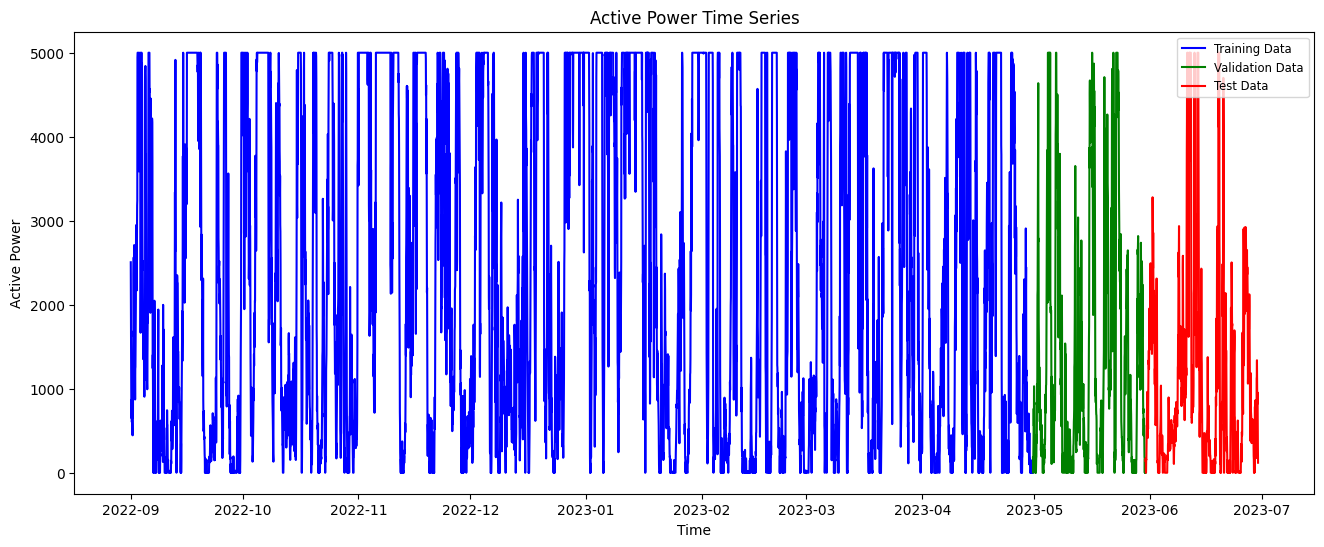

In [15]:
plt.figure(figsize=(16, 6))
plt.plot(train_df["Active_Power"], label="Training Data", color='blue')
plt.plot(val_df["Active_Power"], label="Validation Data", color='green')
plt.plot(test_df["Active_Power"], label="Test Data", color='red')
plt.title("Active Power Time Series")
plt.xlabel("Time")
plt.ylabel("Active Power")
plt.legend(fontsize='small')

We will also create copies of the train, validation, and test sets to use them later in the notebook.

In [16]:
train_df_original = train_df.copy()
val_df_original = val_df.copy()
test_df_original = test_df.copy()

## Data scaling

We apply the min-max scaler fitted to the training set to the train, validation, and test sets (to avoid data leakage). 

In [17]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
scaler.set_output(transform='pandas')

scaler.fit(train_df)
train_df = scaler.transform(train_df)

val_df = scaler.transform(val_df)
test_df = scaler.transform(test_df)

Let us check the result

In [18]:
train_df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Wind_speed_tower,5800.0,0.370283,0.181766,0.0,0.230103,0.341549,0.499679,1.0
Active_Power,5800.0,0.502231,0.396148,0.0,0.112238,0.416912,1.000000,1.0


## Nixtla Dataset Format

Convert to NeuralForecast format (ds, y, unique_id)

In [19]:
train_df_nf = train_df.copy()

train_df_nf = train_df_nf.rename(columns={target: 'y'})

train_df_nf['ds'] = train_df_nf.index

train_df_nf['unique_id'] = 'series_1'


Move ds and unique_id to front

In [20]:
train_df_nf = train_df_nf[['unique_id', 'ds', 'y'] + features]
train_df_nf

,unique_id,ds,y,Wind_speed_tower
time,,,,
2022-09-01 00:00:00,series_1,2022-09-01 00:00:00,0.501096,0.372027
2022-09-01 01:00:00,series_1,2022-09-01 01:00:00,0.352448,0.331578
2022-09-01 02:00:00,series_1,2022-09-01 02:00:00,0.292167,0.316446
2022-09-01 03:00:00,series_1,2022-09-01 03:00:00,0.185362,0.273476
2022-09-01 04:00:00,series_1,2022-09-01 04:00:00,0.134269,0.249839
...,...,...,...,...
2023-04-30 11:00:00,series_1,2023-04-30 11:00:00,0.030030,0.163258
2023-04-30 12:00:00,series_1,2023-04-30 12:00:00,0.000000,0.122068
2023-04-30 13:00:00,series_1,2023-04-30 13:00:00,0.001786,0.055975


Same for validation and test sets

In [21]:
val_df_nf = val_df.copy()
val_df_nf = val_df_nf.rename(columns={target: 'y'})
val_df_nf['ds'] = val_df_nf.index

val_df_nf['unique_id'] = 'series_1'

val_df_nf = val_df_nf[['unique_id', 'ds', 'y'] + features]
val_df_nf

,unique_id,ds,y,Wind_speed_tower
time,,,,
2023-04-30 16:00:00,series_1,2023-04-30 16:00:00,0.035648,0.155312
2023-04-30 17:00:00,series_1,2023-04-30 17:00:00,0.000000,0.141737
2023-04-30 18:00:00,series_1,2023-04-30 18:00:00,0.029513,0.172939
2023-04-30 19:00:00,series_1,2023-04-30 19:00:00,0.054810,0.188957
2023-04-30 20:00:00,series_1,2023-04-30 20:00:00,0.089923,0.207118
...,...,...,...,...
2023-05-30 15:00:00,series_1,2023-05-30 15:00:00,0.000000,0.137377
2023-05-30 16:00:00,series_1,2023-05-30 16:00:00,0.031634,0.149018
2023-05-30 17:00:00,series_1,2023-05-30 17:00:00,0.029638,0.145756


In [22]:
test_df_nf = test_df.copy()
test_df_nf = test_df_nf.rename(columns={target: 'y'})
test_df_nf['ds'] = test_df_nf.index

test_df_nf['unique_id'] = 'series_1'

test_df_nf = test_df_nf[['unique_id', 'ds', 'y'] + features]
test_df_nf

,unique_id,ds,y,Wind_speed_tower
time,,,,
2023-05-30 20:00:00,series_1,2023-05-30 20:00:00,0.028363,0.143479
2023-05-30 21:00:00,series_1,2023-05-30 21:00:00,0.034025,0.152575
2023-05-30 22:00:00,series_1,2023-05-30 22:00:00,0.000000,0.094740
2023-05-30 23:00:00,series_1,2023-05-30 23:00:00,0.000000,0.121221
2023-05-31 00:00:00,series_1,2023-05-31 00:00:00,0.031941,0.149435
...,...,...,...,...
2023-06-29 19:00:00,series_1,2023-06-29 19:00:00,0.168605,0.266810
2023-06-29 20:00:00,series_1,2023-06-29 20:00:00,0.190924,0.276262
2023-06-29 21:00:00,series_1,2023-06-29 21:00:00,0.106156,0.227949


Create a **joint dataset** with train and validation to fit into Nixtla's framework.

In [23]:
train_val_df = pd.concat([train_df_nf, val_df_nf], axis=0)
train_val_df.reset_index(drop=True, inplace=True)
train_val_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6524 entries, 0 to 6523
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   unique_id         6524 non-null   object        
 1   ds                6524 non-null   datetime64[ns]
 2   y                 6524 non-null   float64       
 3   Wind_speed_tower  6524 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 204.0+ KB


And similarly a **full dataset** with train, validation and test sets.

In [24]:
full_df_nf = pd.concat([train_df_nf, val_df_nf, test_df_nf], axis=0)
full_df_nf.reset_index(drop=True, inplace=True)
full_df_nf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7248 entries, 0 to 7247
Data columns (total 4 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   unique_id         7248 non-null   object        
 1   ds                7248 non-null   datetime64[ns]
 2   y                 7248 non-null   float64       
 3   Wind_speed_tower  7248 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(1)
memory usage: 226.6+ KB


## Set the forecast horizon and input length

In [25]:
horizon = 3
input_size = 6

# AutoARIMA

In [26]:
import logging

import optuna

import torch

from neuralforecast import NeuralForecast

from neuralforecast.losses.pytorch import MAE


Check if CUDA is available (Linux machines)

In [27]:
optuna.logging.set_verbosity(optuna.logging.WARNING)
logging.getLogger('pytorch_lightning').setLevel(logging.ERROR)
torch.set_float32_matmul_precision('high')

In [28]:
if torch.cuda.is_available():
    print(torch.cuda.device_count(), torch.cuda.current_device(),torch.cuda.get_device_name(0))

Define the hyperparameters for the model. The first group is fixed and shouldn't changed from model to model. The second group is the hyperparameters that are tuned by the AutoTimeXer algorithm using Optuna as backend and may be specific to the model's architecture. The documentations for the hyperparameters can be seen at the [TimeXer](https://nixtlaverse.nixtla.io/neuralforecast/models.TimeXer.html#TimeXer) and [AutoTimeXer](https://nixtlaverse.nixtla.io/neuralforecast/models.html#autoTimeXer) documentation.

In [29]:
from statsforecast.models import AutoARIMA
from statsforecast import StatsForecast

# Inicializar modelo AutoARIMA
model = StatsForecast(
    models=[AutoARIMA(start_p=1, start_q=1, max_p=3, max_q=3, seasonal=False)],
    freq='H',
    n_jobs=1
)

model

StatsForecast(models=[AutoARIMA])

In [30]:
sf = model.fit(df = train_val_df)


In [32]:

from statsforecast.arima import ARIMASummary


In [33]:
ARIMA_model = sf.fitted_[0][0]


In [34]:
ARIMASummary(ARIMA_model.model_)

Regression with ARIMA(2,0,1) errors

In [35]:
ARIMA_model

AutoARIMA

In [36]:
summaries = []
for mdl in sf.fitted_[0]:
    summary_model = {
        "model": mdl,
        "Orders": ARIMASummary(mdl.model_),
        "sigma2": mdl.model_["sigma2"],
        "loglik": mdl.model_["loglik"],
        "aic": mdl.model_["aic"],
        "aicc": mdl.model_["aicc"],
        "bic": mdl.model_["bic"],
    }
    summaries.append(summary_model)

pd.DataFrame(sorted(summaries, key=lambda d: d["aicc"]))

,model,Orders,sigma2,loglik,aic,aicc,bic
0,AutoARIMA,"Regression with ARIMA(2,0,1) errors",0.004228,8574.830633,-17137.661266,-17137.648377,-17096.961809


In [37]:
summary_model['Orders']

Regression with ARIMA(2,0,1) errors

In [38]:
from copy import deepcopy
print(ARIMASummary(sf.fitted_[0, 0].model_))
coefs = deepcopy(sf.fitted_[0, 0].model_['coef'])
coefs["mean"] = coefs.pop("intercept")
print(f"Coefficients: {coefs}")

Regression with ARIMA(2,0,1) errors
Coefficients: {'ar1': np.float64(1.5639365200960618), 'ar2': np.float64(-0.6132226984428473), 'ma1': np.float64(-0.6489949992405994), 'ex_1': np.float64(1.9783379381595654), 'mean': np.float64(-0.23307334865313575)}


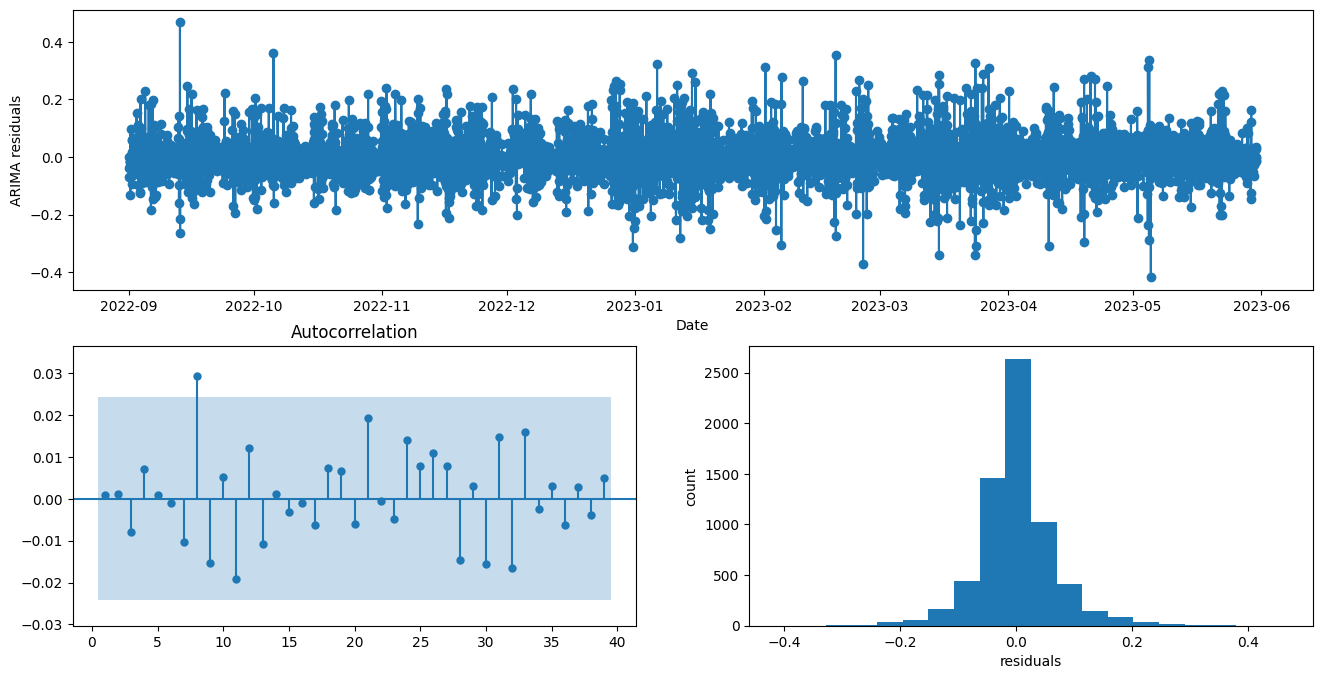

In [39]:
from statsmodels.graphics.tsaplots import plot_acf


fig = plt.figure(figsize=(16, 8))

gs = fig.add_gridspec(2, 2)
ax1 = fig.add_subplot(gs[0, :])
ax2 = fig.add_subplot(gs[1, 0])
ax3 = fig.add_subplot(gs[1, 1])
resids = sf.fitted_[0, 0].model_["residuals"]
ax1.plot(train_val_df['ds'], resids, marker="o")
ax1.set_ylabel('ARIMA residuals')
ax1.set_xlabel('Date')

plot_acf(resids, ax2, zero=False, auto_ylims=True, 
         bartlett_confint=False)

ax3.hist(resids, bins=20)
ax3.set_ylabel('count')
ax3.set_xlabel('residuals')

plt.show();plt.close()

In [40]:
full_df_nf

,unique_id,ds,y,Wind_speed_tower
0,series_1,2022-09-01 00:00:00,0.501096,0.372027
1,series_1,2022-09-01 01:00:00,0.352448,0.331578
2,series_1,2022-09-01 02:00:00,0.292167,0.316446
3,series_1,2022-09-01 03:00:00,0.185362,0.273476
4,series_1,2022-09-01 04:00:00,0.134269,0.249839
...,...,...,...,...
7243,series_1,2023-06-29 19:00:00,0.168605,0.266810
7244,series_1,2023-06-29 20:00:00,0.190924,0.276262
7245,series_1,2023-06-29 21:00:00,0.106156,0.227949
7246,series_1,2023-06-29 22:00:00,0.063234,0.205115


In [41]:
# The value of n moves across the test set, predicting one step at a time
# We use the first row (n = 0) of the test set to initialize the output DataFrame
n = 0 


In [42]:
from utilsforecast.processing import make_future_dataframe

future_predictors = make_future_dataframe(
    train_val_df["unique_id"].unique(),
    pd.to_datetime([train_val_df["ds"].max()]), 
    freq="H", 
    h=horizon,   
)

future_predictors

/Users/fernando/miniconda3/envs/tfm_cc_NIXTLA/lib/python3.13/site-packages/utilsforecast/processing.py:384: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/Users/fernando/miniconda3/envs/tfm_cc_NIXTLA/lib/python3.13/site-packages/utilsforecast/processing.py:440: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)


,unique_id,ds
0,series_1,2023-05-30 20:00:00
1,series_1,2023-05-30 21:00:00
2,series_1,2023-05-30 22:00:00


In [43]:
future_predictors['Wind_speed_tower'] = [train_val_df['Wind_speed_tower'].tail(input_size).mean() for _ in range(future_predictors.shape[0])]
future_predictors

,unique_id,ds,Wind_speed_tower
0,series_1,2023-05-30 20:00:00,0.14096
1,series_1,2023-05-30 21:00:00,0.14096
2,series_1,2023-05-30 22:00:00,0.14096


In [44]:
forecast = sf.predict(h=3, X_df=future_predictors)
forecast

/Users/fernando/miniconda3/envs/tfm_cc_NIXTLA/lib/python3.13/site-packages/utilsforecast/processing.py:384: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)
/Users/fernando/miniconda3/envs/tfm_cc_NIXTLA/lib/python3.13/site-packages/utilsforecast/processing.py:440: FutureWarning: 'H' is deprecated and will be removed in a future version, please use 'h' instead.
  freq = pd.tseries.frequencies.to_offset(freq)


,unique_id,ds,AutoARIMA
0,series_1,2023-05-30 20:00:00,0.043475
1,series_1,2023-05-30 21:00:00,0.044780
2,series_1,2023-05-30 22:00:00,0.045631


Now we create a dictionary (of dataframes) to store the predictions for each value k from 1 to the max of the prediction horizon. The weird (k-1):k bit below is to prevent pandas from collapsing the row into a series!

In [45]:
ARIMA_dict = {}

for h in range(1, horizon + 1):
# for h in range(1, 2):

    # Initialize the dictionary to store models and parameters for each horizon
    ARIMA_dict[f'{h}h'] = {'preds': forecast.iloc[(h - 1):h, :]}

ARIMA_dict['2h']['preds']

,unique_id,ds,AutoARIMA
1,series_1,2023-05-30 21:00:00,0.04478


In [46]:
%%capture

start_time = time.time()


# This loop iterates over the remaining rows of the test set, predicting one step at a time
# using the same steps
# for n in range(1, 10):
for n in range(1, test_df_nf.shape[0] - h + 1):

    print(f"Processing row {n} of the test set")
    train_val_df_n = full_df_nf.head(train_val_df.shape[0] + n).copy()

    sf_n = model.fit(df = train_val_df_n)


    future_predictors = make_future_dataframe(
    train_val_df_n["unique_id"].unique(),
    pd.to_datetime([train_val_df_n["ds"].max()]), 
    freq="H", 
    h=horizon,   
)

    future_predictors['Wind_speed_tower'] = [train_val_df_n['Wind_speed_tower'].tail(input_size).mean() for _ in range(future_predictors.shape[0])]

    forecast = sf.predict(h=3, X_df=future_predictors)

    for h in range(1, horizon + 1):
        
        ARIMA_dict[f'{h}h']['preds'] =   pd.concat([ARIMA_dict[f'{h}h']['preds'], forecast.iloc[(h - 1):h, :]], axis=0)
        ARIMA_dict[f'{h}h'][f'model_{n}'] = sf_n.fitted_[0, 0].model_
# future_predictors
# forecast
# ARIMA_dict['2h']['preds']

end_time = time.time()
elapsed_time = end_time - start_time    

In [47]:
print(f"Elapsed time: {elapsed_time:.2f} seconds")

Elapsed time: 4387.38 seconds


# Model Performance Evaluation

Let us also look at the prediction dataframes for the ARIMAoost models for each prediction horizon.

In [48]:
preds_df = {}

In [49]:
preds_df['1h'] = ARIMA_dict['1h']['preds'].set_index('ds').rename(columns={'AutoARIMA': 'pred_1h'})
preds_df['1h']

,unique_id,pred_1h
ds,,
2023-05-30 20:00:00,series_1,0.043475
2023-05-30 21:00:00,series_1,0.014647
2023-05-30 22:00:00,series_1,0.008416
2023-05-30 23:00:00,series_1,0.064358
2023-05-31 00:00:00,series_1,0.006961
...,...,...
2023-06-29 17:00:00,series_1,0.155737
2023-06-29 18:00:00,series_1,0.169069
2023-06-29 19:00:00,series_1,0.187468


In [50]:
preds_df['2h'] = ARIMA_dict['2h']['preds'].set_index('ds').rename(columns={'AutoARIMA': 'pred_2h'})
preds_df['2h']

,unique_id,pred_2h
ds,,
2023-05-30 21:00:00,series_1,0.044780
2023-05-30 22:00:00,series_1,0.017447
2023-05-30 23:00:00,series_1,0.012439
2023-05-31 00:00:00,series_1,0.060742
2023-05-31 01:00:00,series_1,0.007650
...,...,...
2023-06-29 18:00:00,series_1,0.167404
2023-06-29 19:00:00,series_1,0.182423
2023-06-29 20:00:00,series_1,0.201999


In [51]:
preds_df['3h'] = ARIMA_dict['3h']['preds'].set_index('ds').rename(columns={'AutoARIMA': 'pred_3h'})
preds_df['3h']

,unique_id,pred_3h
ds,,
2023-05-30 22:00:00,series_1,0.045631
2023-05-30 23:00:00,series_1,0.019982
2023-05-31 00:00:00,series_1,0.016216
2023-05-31 01:00:00,series_1,0.056582
2023-05-31 02:00:00,series_1,0.008345
...,...,...
2023-06-29 19:00:00,series_1,0.177721
2023-06-29 20:00:00,series_1,0.194555
2023-06-29 21:00:00,series_1,0.215259


And let us plot the predictions of the ARIMAoost models for each prediction horizon.

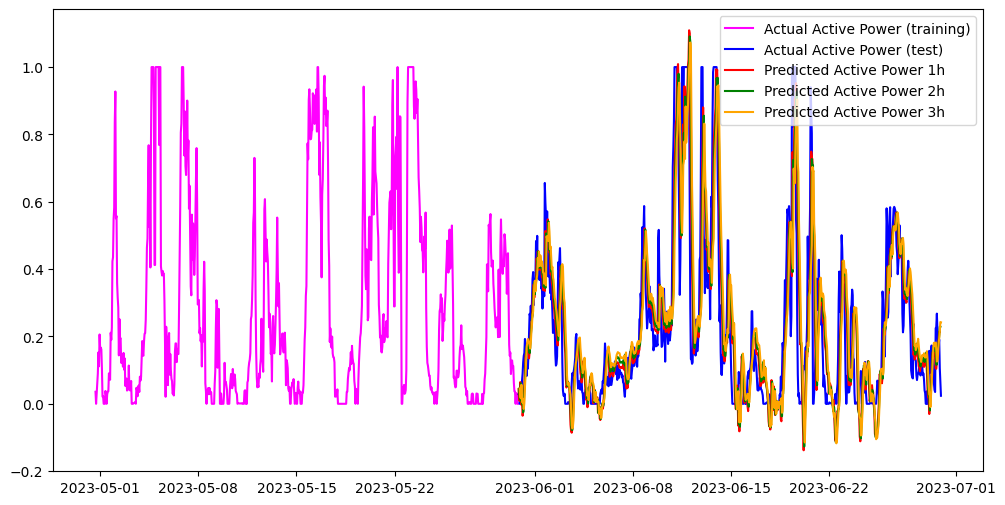

In [52]:
%matplotlib inline

plt.figure(figsize=(12, 6))
plt.plot(val_df_nf["y"], label="Actual Active Power (training)", color='magenta')
plt.plot(test_df_nf["y"], label="Actual Active Power (test)", color='blue')
for h in range(1, horizon + 1):
    colors = ['red', 'green', 'orange', 'purple', 'brown', 'cyan']
    plt.plot(
        preds_df[f'{h}h'][f'pred_{h}h'],
        label=f"Predicted Active Power {h}h",
        color=colors[(h - 1) % len(colors)]
    )
plt.legend()
plt.show();plt.close()


### MAE computation

We will next compute the MAE for each of the predictions in the dictionary. 

In [53]:
from sklearn.metrics import mean_absolute_error

#### Mae for 1h preddictions

In [54]:
mae1h_df = preds_df['1h'].copy()[['pred_1h']]
mae1h_df


,pred_1h
ds,
2023-05-30 20:00:00,0.043475
2023-05-30 21:00:00,0.014647
2023-05-30 22:00:00,0.008416
2023-05-30 23:00:00,0.064358
2023-05-31 00:00:00,0.006961
...,...
2023-06-29 17:00:00,0.155737
2023-06-29 18:00:00,0.169069
2023-06-29 19:00:00,0.187468


We need to add the exogenous variables as they were used by the scaler. 

In [56]:
mae1h_df.insert(0, 'Wind_speed_tower', test_df_nf['Wind_speed_tower'].values[:-2])
mae1h_df

,Wind_speed_tower,pred_1h
ds,,
2023-05-30 20:00:00,0.143479,0.043475
2023-05-30 21:00:00,0.152575,0.014647
2023-05-30 22:00:00,0.094740,0.008416
2023-05-30 23:00:00,0.121221,0.064358
2023-05-31 00:00:00,0.149435,0.006961
...,...,...
2023-06-29 17:00:00,0.284871,0.155737
2023-06-29 18:00:00,0.262979,0.169069
2023-06-29 19:00:00,0.266810,0.187468


In [63]:
# mae1h_df.columns = ["Wind_speed_tower", "Active_Power"]
mean_absolute_error(scaler.inverse_transform(mae1h_df)[:,1], test_df_original["Active_Power"][:-2])

464.4386864793

#### Mae for 2h preddictions

In [64]:
mae2h_df = preds_df['2h'].copy()[['pred_2h']]
mae2h_df


,pred_2h
ds,
2023-05-30 21:00:00,0.044780
2023-05-30 22:00:00,0.017447
2023-05-30 23:00:00,0.012439
2023-05-31 00:00:00,0.060742
2023-05-31 01:00:00,0.007650
...,...
2023-06-29 18:00:00,0.167404
2023-06-29 19:00:00,0.182423
2023-06-29 20:00:00,0.201999


In [65]:
mae2h_df.insert(0, 'Wind_speed_tower', test_df_nf['Wind_speed_tower'].values[:-2])
mae2h_df

,Wind_speed_tower,pred_2h
ds,,
2023-05-30 21:00:00,0.143479,0.044780
2023-05-30 22:00:00,0.152575,0.017447
2023-05-30 23:00:00,0.094740,0.012439
2023-05-31 00:00:00,0.121221,0.060742
2023-05-31 01:00:00,0.149435,0.007650
...,...,...
2023-06-29 18:00:00,0.284871,0.167404
2023-06-29 19:00:00,0.262979,0.182423
2023-06-29 20:00:00,0.266810,0.201999


In [66]:
# mae1h_df.columns = ["Wind_speed_tower", "Active_Power"]
mean_absolute_error(scaler.inverse_transform(mae2h_df)[:,1], test_df_original["Active_Power"][:-2])

471.5039853062987

#### Mae for 3h preddictions

In [67]:
mae3h_df = preds_df['3h'].copy()[['pred_3h']]
mae3h_df


,pred_3h
ds,
2023-05-30 22:00:00,0.045631
2023-05-30 23:00:00,0.019982
2023-05-31 00:00:00,0.016216
2023-05-31 01:00:00,0.056582
2023-05-31 02:00:00,0.008345
...,...
2023-06-29 19:00:00,0.177721
2023-06-29 20:00:00,0.194555
2023-06-29 21:00:00,0.215259


In [68]:
mae3h_df.insert(0, 'Wind_speed_tower', test_df_nf['Wind_speed_tower'].values[:-2])
mae3h_df

,Wind_speed_tower,pred_3h
ds,,
2023-05-30 22:00:00,0.143479,0.045631
2023-05-30 23:00:00,0.152575,0.019982
2023-05-31 00:00:00,0.094740,0.016216
2023-05-31 01:00:00,0.121221,0.056582
2023-05-31 02:00:00,0.149435,0.008345
...,...,...
2023-06-29 19:00:00,0.284871,0.177721
2023-06-29 20:00:00,0.262979,0.194555
2023-06-29 21:00:00,0.266810,0.215259


In [69]:
mean_absolute_error(scaler.inverse_transform(mae3h_df)[:,1], test_df_original["Active_Power"][:-2])

482.91945701908855